# Data

### Download data

In [1]:
!wget 'https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar'

--2023-02-08 15:56:00--  https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 811315200 (774M) [application/x-tar]
Saving to: ‘wiki_crop.tar’

wiki_crop.tar       100%[===================>] 773.73M  9.89MB/s    in 82s     

2023-02-08 15:57:24 (9.39 MB/s) - ‘wiki_crop.tar’ saved [811315200/811315200]



### Unzip

In [2]:
import tarfile
my_tar = tarfile.open('wiki_crop.tar')
my_tar.extractall('./')
my_tar.close()

### Load meta data

In [3]:
from pathlib import Path
meta_data_path = Path('wiki_crop/wiki.mat')

In [4]:
from scipy.io import loadmat

meta_data = loadmat(meta_data_path)

### Create CSV

In [5]:
import numpy as np
from scipy.io import loadmat
import pandas as pd
import datetime as date
from dateutil.relativedelta import relativedelta

cols = ['age', 'gender', 'path', 'face_score1', 'face_score2']

wiki_mat = 'wiki_crop/wiki.mat'

wiki_data = loadmat(wiki_mat)

del wiki_mat

wiki = wiki_data['wiki']

wiki_photo_taken = wiki[0][0][1][0]
wiki_full_path = wiki[0][0][2][0]
wiki_gender = wiki[0][0][3][0]
wiki_face_score1 = wiki[0][0][6][0]
wiki_face_score2 = wiki[0][0][7][0]

wiki_path = []

for path in wiki_full_path:
    wiki_path.append('wiki_crop/' + path[0])

wiki_genders = []

for n in range(len(wiki_gender)):
    if wiki_gender[n] == 1:
        wiki_genders.append('male')
    else:
        wiki_genders.append('female')

wiki_dob = []

for file in wiki_path:
    wiki_dob.append(file.split('_')[2])

wiki_age = []

for i in range(len(wiki_dob)):
    try:
        d1 = date.datetime.strptime(wiki_dob[i][0:10], '%Y-%m-%d')
        d2 = date.datetime.strptime(str(wiki_photo_taken[i]), '%Y')
        rdelta = relativedelta(d2, d1)
        diff = rdelta.years
    except Exception as ex:
        print(ex)
        diff = -1
    wiki_age.append(diff)

final_wiki = np.vstack((wiki_age, wiki_genders, wiki_path, wiki_face_score1, wiki_face_score2)).T

final_wiki_df = pd.DataFrame(final_wiki)

final_wiki_df.columns = cols

meta = final_wiki_df

meta = meta[meta['face_score1'] != '-inf']
meta = meta[meta['face_score2'] == 'nan']

meta = meta.drop(['face_score1', 'face_score2'], axis=1)

meta = meta.sample(frac=1)

meta.to_csv('meta.csv', index=False)

time data '829-09-08' does not match format '%Y-%m-%d'
time data '1823-12-00' does not match format '%Y-%m-%d'
time data '1953-10-00' does not match format '%Y-%m-%d'
time data '1984-15-03' does not match format '%Y-%m-%d'
time data '1963-02-00' does not match format '%Y-%m-%d'
time data '1977-04-00' does not match format '%Y-%m-%d'
time data '1946-05-00' does not match format '%Y-%m-%d'
time data '647-05-15' does not match format '%Y-%m-%d'
time data '11-03-00' does not match format '%Y-%m-%d'
time data '1980-05-00' does not match format '%Y-%m-%d'
time data '1960-02-00' does not match format '%Y-%m-%d'
time data '1975-03-00' does not match format '%Y-%m-%d'
time data '1952-11-00' does not match format '%Y-%m-%d'
time data '1974-04-00' does not match format '%Y-%m-%d'
time data '1996-25-05' does not match format '%Y-%m-%d'
time data '1914-02-00' does not match format '%Y-%m-%d'


In [57]:
import pandas as pd

meta_df = pd.read_csv('meta.csv')
meta_df

,age,gender,path
0,22,male,wiki_crop/45/14411545_1990-04-07_2013.jpg
1,28,male,wiki_crop/47/24209747_1985-07-01_2014.jpg
2,34,male,wiki_crop/29/38615529_1978-01-30_2013.jpg
3,28,female,wiki_crop/25/32426325_1979-03-24_2008.jpg
4,56,male,wiki_crop/89/1971989_1951-12-08_2008.jpg
...,...,...,...
40211,63,male,wiki_crop/62/3184362_1949-02-10_2013.jpg
40212,54,female,wiki_crop/01/2079601_1903-11-07_1958.jpg
40213,24,male,wiki_crop/78/2523378_1986-01-03_2011.jpg
40214,20,male,wiki_crop/91/16309991_1989-11-27_2010.jpg


### Create dataset

In [58]:
import pandas as pd
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split

meta = pd.read_csv('meta.csv')

meta = meta.drop(['gender'], axis=1)

meta = meta[meta['age'] >= 0]
meta = meta[meta['age'] <= 101]

meta = meta.values

D_train, D_test = train_test_split(meta, test_size=0.1, random_state=42)

dataset_path = 'dataset/'

# Making the directory structure
for i in range(102):
    output_dir_train = dataset_path + '/train/' + str(i)
    output_dir_test = dataset_path + '/test/' + str(i)

    if not os.path.exists(output_dir_train):
        os.makedirs(output_dir_train)
        
    if not os.path.exists(output_dir_test):
        os.makedirs(output_dir_test)

# Finally making the training and testing set
counter = 0
for image in D_train:
    img = cv2.imread(image[1], 1)
    cv2.imwrite(dataset_path + 'train/' + str(image[0]) + '/' + str(counter) + '.jpg', img)
    print('--('+str(counter)+')Processing--')
    counter += 1

counter = 0
for image in D_test:
    img = cv2.imread(image[1], 1)
    cv2.imwrite(dataset_path + 'test/' + str(image[0]) + '/' + str(counter) + '.jpg', img)
    print('--('+str(counter)+')Processing--')
    counter += 1

--(0)Processing--
--(1)Processing--
--(2)Processing--
--(3)Processing--
--(4)Processing--
--(5)Processing--
--(6)Processing--
--(7)Processing--
--(8)Processing--
--(9)Processing--
--(10)Processing--
--(11)Processing--
--(12)Processing--
--(13)Processing--
--(14)Processing--
--(15)Processing--
--(16)Processing--
--(17)Processing--
--(18)Processing--
--(19)Processing--
--(20)Processing--
--(21)Processing--
--(22)Processing--
--(23)Processing--
--(24)Processing--
--(25)Processing--
--(26)Processing--
--(27)Processing--
--(28)Processing--
--(29)Processing--
--(30)Processing--
--(31)Processing--
--(32)Processing--
--(33)Processing--
--(34)Processing--
--(35)Processing--
--(36)Processing--
--(37)Processing--
--(38)Processing--
--(39)Processing--
--(40)Processing--
--(41)Processing--
--(42)Processing--
--(43)Processing--
--(44)Processing--
--(45)Processing--
--(46)Processing--
--(47)Processing--
--(48)Processing--
--(49)Processing--
--(50)Processing--
--(51)Processing--
--(52)Processing--
--(

# Distribution

In [59]:
from fastai.data.all import *

In [60]:
path = Path('dataset')
path.ls()

(#2) [Path('dataset/test'),Path('dataset/train')]

In [61]:
distribution_train = []
distribution_test = []

for i in range(101):
  distribution_train.append(len(get_image_files(path/f'train/{i}')))

for i in range(101):
  distribution_test.append(len(get_image_files(path/f'test/{i}')))

print('Number of train images: ' + str(sum(distribution_train)))
print('Number of test images: ' + str(sum(distribution_test)))

Number of train images: 36143
Number of test images: 4016


### Distribution in training set

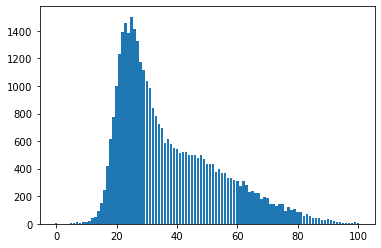

In [62]:
import matplotlib.pyplot as plt
import numpy as np

plt.bar(np.arange(len(distribution_train)), np.array(distribution_train))
plt.show()

### Distribution in test set

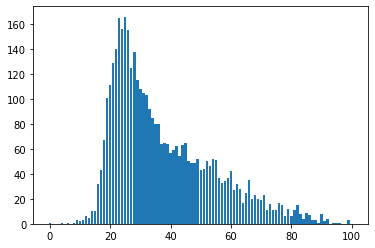

In [63]:
import matplotlib.pyplot as plt
import numpy as np

plt.bar(np.arange(len(distribution_test)), np.array(distribution_test))
plt.show()

# Train

### Create DataBlock

In [64]:
from fastai.vision.all import *

def get_parent_as_int(o):
  return int(Path(o).parent.name)

images = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=get_parent_as_int,
    item_tfms=Resize(128)
)

In [65]:
dls = images.dataloaders(path/'train')

### Examples

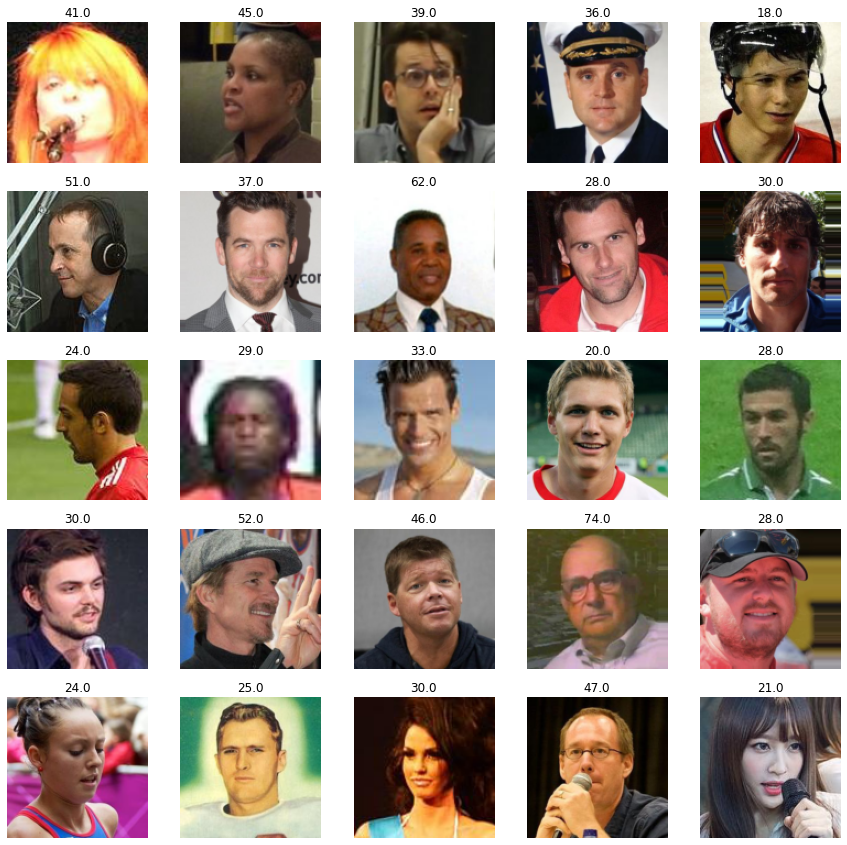

In [66]:
dls.valid.show_batch(max_n=25, nrows=5)

### Learn

In [67]:
learn = vision_learner(dls, resnet18, metrics=mae)
learn.recorder.train_metrics = True
learn.fine_tune(4)

epoch,train_loss,train_mae,valid_loss,valid_mae,time
0,307.784180,27.889482,173.628448,10.191091,03:05


epoch,train_loss,train_mae,valid_loss,valid_mae,time
0,137.344696,9.484435,108.772690,7.886971,03:07
1,107.105019,8.117685,97.937820,7.439658,03:05
2,68.598000,6.613269,93.170990,7.228432,03:06
3,45.650837,5.381614,91.326508,7.133195,03:06


In [72]:
learn2 = vision_learner(dls, resnet18, metrics=mae)
learn2.recorder.train_metrics = True
learn2.fine_tune(2)

epoch,train_loss,train_mae,valid_loss,valid_mae,time
0,303.663025,27.918013,168.589447,9.960782,03:03


epoch,train_loss,train_mae,valid_loss,valid_mae,time
0,132.152313,9.420413,105.384705,7.730822,03:06
1,94.068810,7.588961,95.538673,7.334030,03:05


In [75]:
learn2.export('model.pkl')

# Evaluating

In [73]:
from fastai.data.all import *
from fastai.vision.all import * 

test_images_path = Path('dataset/test')
test_images = get_image_files(test_images_path)

pred_mae = np.array([])

for image in test_images:
    img = Image.open(image)
    with learn2.no_bar(), learn2.no_logging():
        pred_data, _, _ = learn2.predict(image)
    prediction = round(pred_data[0], 1)
    correct_label = int(Path(image).parent.name)
    pred_mae = np.append(pred_mae2, abs(prediction - correct_label))

In [74]:
test_mae = np.mean(pred_mae)
print(f'Testset - mean absolute error: {test_mae}')

Testset - mean absolute error 2: 7.332860343539956


# Gradio

In [19]:
learn_inf = load_learner('model.pkl')

In [21]:
#!pip install gradio
import gradio as gr

def image_to_text(image):
    prediction, _, _ = learn_inf.predict(image)
    return round(prediction[0], 1)

inputs = gr.inputs.Image()
output = gr.outputs.Textbox()

interface = gr.Interface(fn=image_to_text, inputs=inputs, outputs=output, title="Image to Text")
interface.launch()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 13.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 46.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 6.8 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4712 sha256=2e3c503d2b6182305209ca5ed92ad81aa3fe39c7bf3b3e389d75a712cc80c5cb
  Stored in directory: /root/.cache/pip/wheels/13/e4/6c/e8059816e86796a597c6e6b0d4c880630f51a1fcfa0befd5e6
  Created wheel for python-multipart: filename=python_multipart-0.0.5-py3-none-any.whl size=31678 sha256=fe96fce1640d259c73d87e18a13894f39a5ce741d9efbe48df5368e216453f2e
  Stored in directory: /root/.cache/pip/wheels/2c/41/7c/bfd1c180534ffdcc0972f78c5758f89881602175d48a8bcd2c
Successfully built ffmpy python-multipart


/opt/conda/lib/python3.7/site-packages/gradio/inputs.py:258: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
/opt/conda/lib/python3.7/site-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/opt/conda/lib/python3.7/site-packages/gradio/outputs.py:23: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  "Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components",


Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://d78912df-b7a9-4090.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
